In [1]:
%matplotlib inline
import json
import os
import csv
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from matplotlib.image import imread
import torch
from rise.explanations import RISE
from rise.utils import tensor_imshow, read_tensor
from analyze import load_model

In [2]:
BBOX_CSV_FILE = os.path.join('..', 'data', 'BBox_List_2017.csv')
ORIGINAL = 1024
SCALE = 224
SCALE_FACTOR = SCALE / ORIGINAL

In [3]:
with open('best10.json') as f:
    json_data = json.load(f)
data = {}
for label, images in json_data.items():
    if len(images) > 0:
        data[label] = images

In [ ]:
bboxes = {}
with open(BBOX_CSV_FILE) as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader) # skip header
    for row in reader:
        image, _, x, y, w, h, *_ = row
        bboxes[image] = {
            'x': float(x) * SCALE_FACTOR,
            'y': float(y) * SCALE_FACTOR,
            'w': float(w) * SCALE_FACTOR,
            'h': float(h) * SCALE_FACTOR,
        }

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 1
dataset, loader, model = load_model(device, batch_size)
num_classes = len(dataset.classes)

MASKS_PATH = 'rise_masks.npy'
explainer = RISE(model, (224, 224), batch_size)
if not os.path.exists(MASKS_PATH):
    explainer.generate_masks(N=6000, s=8, p1=0.1, savepath=MASKS_PATH)
else:
    explainer.load_masks(MASKS_PATH)

def get_class_name(label):
    return dataset.classes[label]

def example(image_path, top_k, label, bbox):
    bbox_image = Image.open(image_path)
    draw = ImageDraw.Draw(bbox_image)
    draw.rectangle((bbox['x'], bbox['y'], bbox['x'] + bbox['w'], bbox['y'] + bbox['h']), outline='red')
    
    img = read_tensor(image_path)
    device_img = img.to(device)
    saliency = explainer(device_img).cpu().numpy()

    p, c = torch.topk(model(device_img), k=top_k)
    p, c = p[0], c[0]
    
    plt.figure(figsize=(10, 5*top_k))
    for k in range(top_k):
        plt.subplot(top_k, 2, 2*k+1)
        plt.axis('off')
        plt.title('{:.2f}% {} {}'.format(100*p[k], get_class_name(c[k]), label))
        #tensor_imshow(img[0])
        plt.imshow(bbox_image)

        plt.subplot(top_k, 2, 2*k+2)
        plt.axis('off')
        plt.title(get_class_name(c[k]))
        tensor_imshow(img[0])
        sal = saliency[c[k]]
        plt.imshow(sal, cmap='jet', alpha=0.5)
        plt.colorbar(fraction=0.046, pad=0.04)

    plt.show()

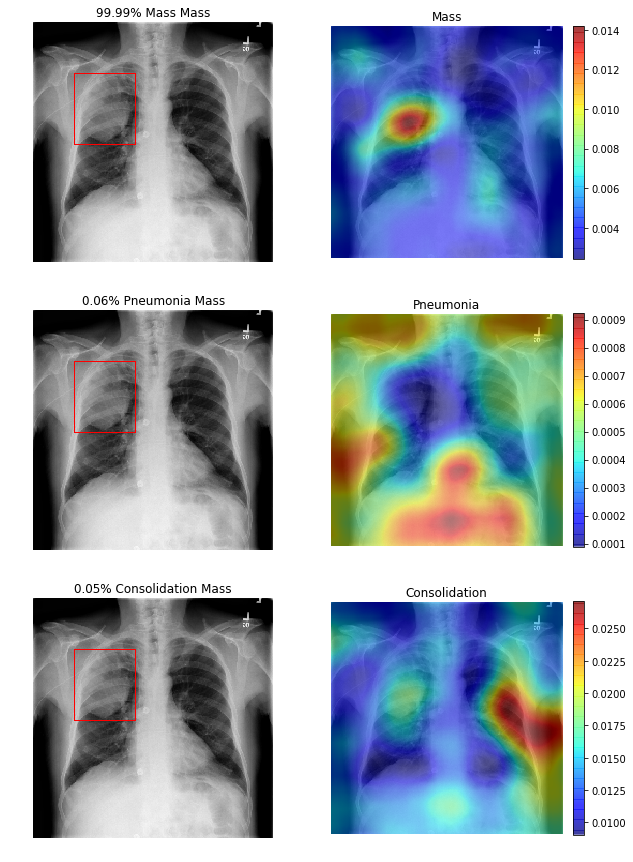

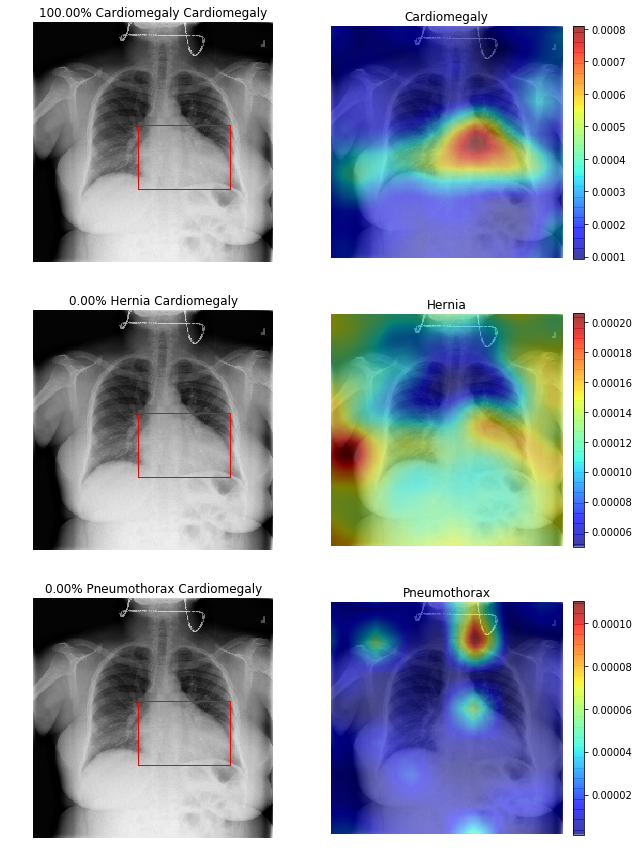

In [ ]:
with torch.set_grad_enabled(False):
    for label, images in data.items():
        for image in images:
            image_name = image['image']
            if image_name in bboxes:
                bbox = bboxes[image_name]
                image_path = os.path.join('..', 'data', 'processed_images', image_name)
                example(image_path, 3, label, bbox)